### 네이버에서 크롤링한 영화리뷰 데이터를 이용한 긍부정 분석
- 네이버 영화리뷰를 크롤링
- 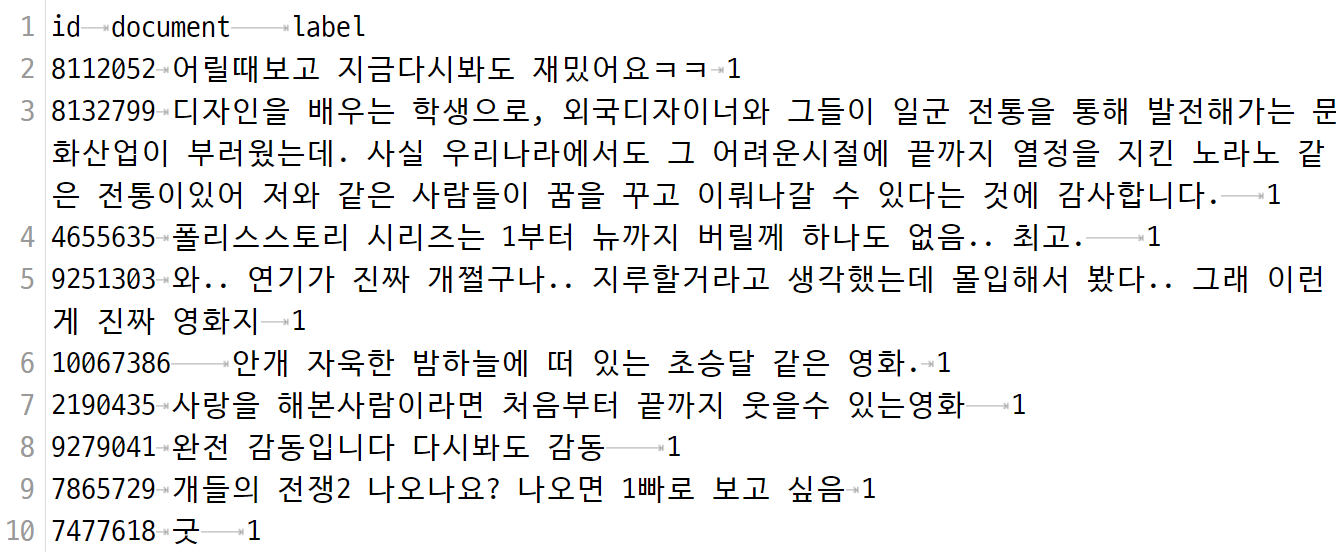
- 평점이 5 초과면 긍정리뷰, 이하면 부정리뷰로 정하고
    - 긍정리뷰 75000 부정리뷰 75000개 수집
- 데이터구성
    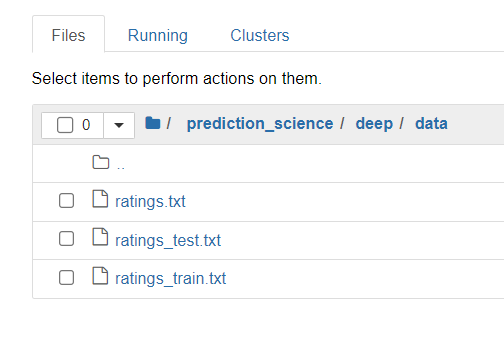

### 리뷰 데이터 준비

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity="all"

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="./data/ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="./data/ratings_test.txt")

('./data/ratings_train.txt', <http.client.HTTPMessage at 0x29b897f8b30>)

('./data/ratings_test.txt', <http.client.HTTPMessage at 0x29b897f8f50>)

In [4]:
#트레인 파일 불러오기
train_data = pd.read_csv('./data/ratings_train.txt',header = 0, delimiter = '\t', quoting=3)
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [5]:
print('학습데이터 전체 개수: {}'.format(len(train_data)))

학습데이터 전체 개수: 150000


In [6]:
#리뷰 문자길이 확인
train_length = train_data['document'].astype(str).apply(len)
train_length.head()

0    19
1    33
2    17
3    29
4    61
Name: document, dtype: int64

In [7]:
#리뷰 통계 정보
print('리뷰 길이 최댓값: {}'.format(np.max(train_length)))
print('리뷰 길이 최솟값: {}'.format(np.min(train_length)))
print('리뷰 길이 평균값: {:.2f}'.format(np.mean(train_length)))
print('리뷰 길이 표준편차: {:.2f}'.format(np.std(train_length)))
print('리뷰 길이 중간값: {}'.format(np.median(train_length)))
print('리뷰 길이 제1사분위: {}'.format(np.percentile(train_length,25)))
print('리뷰 길이 제3사분위: {}'.format(np.percentile(train_length,75)))

리뷰 길이 최댓값: 158
리뷰 길이 최솟값: 1
리뷰 길이 평균값: 35.24
리뷰 길이 표준편차: 29.58
리뷰 길이 중간값: 27.0
리뷰 길이 제1사분위: 16.0
리뷰 길이 제3사분위: 42.0


- 리뷰의 평균길이는 35.24
- 중간값과 차이가 있고 편차가 29정도인걸 보면 리뷰길이의 범위가 차이가 많이 남

In [8]:
#긍정 1, 부정 0
print('긍정 리뷰 갯수: {}'.format(train_data['label'].value_counts()[1]))
print('부정 리뷰 갯수: {}'.format(train_data['label'].value_counts()[0]))

긍정 리뷰 갯수: 74827
부정 리뷰 갯수: 75173


### 긍/부정 분석을 위한 자연처 처리
- 문자열 데이터를 수치화 하기 위한 작업

### 데이터 전처리

- 5단계로 진행

1. 정규화로 한국어만 남기기

2. 형태소 분석기로 어간 추출하기

3. 불용어 제거하기

4. 문자를 인덱스벡터로 전환하기

5. 패딩처리하기

- 한국어 텍스트를 전처리할 때는 konlpy의 okt()를 사용하여 형태소 분석
    - okt()는 트위터사에서 제작한 한글 형태소 분석기

In [9]:
# !pip uninstall konlpy

In [10]:
import konlpy

In [11]:
import numpy as np
import pandas as pd
import re
import json
# 한글 형태소 분석기 okt 사용
# open korean text 형태소 분석기(트위터에서 제작한것을 이어받아 진행하고 있는 프로젝트)
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

train_data = pd.read_csv('./data/ratings_train.txt', header = 0, delimiter='\t', quoting=3)
train_data['document'][:5]

0                                  아 더빙.. 진짜 짜증나네요 목소리
1                    흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
2                                    너무재밓었다그래서보는것을추천한다
3                        교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
4    사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...
Name: document, dtype: object

1. 전처리 함수 생성
- 한글과 공백제외 모두제거
    - [^가-힣ㄱ-ㅎㅏ-ㅣ\\s] 한글과 공백문자 정규식
    - 가-힣, ㄱ-ㅎ, ㅏ-ㅣ, \s(공백)
- 불용어 제거

In [3]:
import re # 정규식 함수
# sub(정규식, 대체문자, 확인대상문자열) : 어떠한 패턴을 특정 문자열로 대체
# 한글 가~힣(모든 한글 글자)
# 한글 자음
# 한글 모음 을 제외한 나머지 글자는 공백으로 대체
# 공백문자도 남김

re.sub('[^가-힣 ㄱ-ㅎ ㅏ-ㅣ]', ' ', '가나다 abc ^%### 1234 뮤직')

'가나다                뮤직'

- 위 결과를 보면 한글이 아닌 영문과 특수문자는 공백으로 대체 됨

2. 전체 학습데이터 및 평가데이터 리뷰 전처리하기

In [4]:
review = '교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정'
#  1. 한글 및 공백 제외한 문자 모두 제거
review_text = re.sub('[^가-힣 ㄱ-ㅎ ㅏ-ㅣ\\ㄴ]', ' ', review)
review_text

'교도소 이야기구먼   솔직히 재미는 없다  평점 조정'

### 한글 형태소 단위 토크나이징
- KoNLPy 사용
    - KoNLPy에서는 여러 형태소 분석기를 제공하며, 각 형태소 분석기별로 분석한 결과는 다를 수 있다.
    - 각 형태소 분석기는 클래스 형태로 되어 있고 이를 객체로 생성한 후 매서드를 호출해서 토크나이징할 수 있다.

- 형태소 분석 및 품사 태깅
    - 형태소란 의미를 가지는 가장 작은 단위로서 더 쪼개지면 의미를 상실하는 것들을 말한다.
    - 형태소 분석이란 의미를 가지는 단위를 기준으로 문장을 살펴보는 것을 의미한다.
    - KoNLPy는 기존에 C, C++, Java 등의 언어를 통해 형태소 분석을 할 수 있는 좋은 라이브러리들을 파이썬 라이브러리로 통합해서 사용할 수 있록 하여 한국어 구문 분석을 쉽게 할 수 있도록 만들어진 라이브러리이다.
    - KoNLPy에는 다양한 형태소 분석기들이 객체 형태로 포함돼 있으며 다음과 같은 각 형태소 분석기 목록이 있다.
        - Hannanum
        - Kkma
        - Komoran
        - Mecab
        - Okt(Twitter)
        - 모두 동일한 형태소 분석 기능 제공하지만 각기 성능이 조금씩 다름

- Okt 사용
    1. 객체 생성
        - Okt() 생성자 함수 이용
    2. 필요 함수 사용
    - okt.morphs() 텍스트를 형태소 단위로 나눈다. 옵션으로 norm과 stem이 있다. norm은 문장을 정규화. stem은 각 단어에서 어간을 추출.(기본값은 둘다 False)
    - okt.nouns() 텍스트에서 명사만 뽑아낸다.
    - okt.phrases() 텍스트에서 어절을 뽑아낸다.
    - okt.pos() 각 품사를 태깅하는 역할을 한다. 품사를 태깅한다는 것은 주어진 텍스트를 형태소 단위로 나누고, 나눠진 각 형태소를 그에 해당하는 품사와 함께 리스트화하는 것을 의미한다. 옵션으로 norm, stem, join이 있는데 join은 나눠진 형태소와 품사를 ‘형태소/품사’ 형태로 같이 붙여서 리스트화한다.

In [14]:
# !pip3 install jpype1

In [13]:
import jpype
# jpype.startJVM()
if not jpype.isJVMStarted():
    print("JVM이 실행되지 않았습니다.")
else:
    print("JVM이 정상적으로 실행 중입니다.")

JVM이 정상적으로 실행 중입니다.


In [5]:
from konlpy.tag import Okt
#2. okt 객체를 활용하여 형태소 단어로 나눔
okt = Okt()
word_review = okt.morphs(review_text, stem=True)
word_review

['교도소', '이야기', '구먼', '솔직하다', '재미', '는', '없다', '평점', '조정']

In [47]:
# 3. stop_words 제거(불용어) - 주관적으로 분석가에 의해 결정됨
# 보통 불용어는 불용어 집합을 찾아서 활용한다
stop_words = ['은','는','이','가','하','아','것','들','의','있','되','수','보','주','등','한']
s_list = [tk for tk in word_review if not tk in stop_words]

In [48]:
# 4. 추출된 형태소에서 불용어 제거된 결과 단어를 token의 word_index로 변환
# 케라스 Tokenizer()
tokenizer = Tokenizer()
tokenizer.fit_on_texts(s_list)
tokenizer.word_index
t_seq = tokenizer.texts_to_sequences(s_list)
t_seq = np.reshape(t_seq, (1, -1))
t_seq

{'교도소': 1, '이야기': 2, '구먼': 3, '솔직하다': 4, '재미': 5, '없다': 6, '평점': 7, '조정': 8}

array([[1, 2, 3, 4, 5, 6, 7, 8]])

In [49]:
# 5. tokenizer가 생성한 단어사전을 저장해야 테스트 데이터와 예측 진행시 사용할 수 있음
#단어사전형태
word_vocab =tokenizer.word_index # word_vocab을 저장해둬야 (디스크에 저장 진행)
MAX_SEQUENCE_LENGTH = 10 #문장 최대 길이

#학습 데이터
train_inputs = pad_sequences(t_seq, maxlen=MAX_SEQUENCE_LENGTH, padding="post")
train_inputs

array([[1, 2, 3, 4, 5, 6, 7, 8, 0, 0]], dtype=int32)

### 위 과정을 모두 처리하는 전처리 함수 만들기

In [50]:
#전처리 함수 만들기
def preprocessing(review, okt, remove_stopwords = False, stop_words =[]):

    review_text = re.sub('[^가-힣 ㄱ-ㅎ ㅏ-ㅣ\\ㄴ]', ' ', review)
    word_review = okt.morphs(review_text, stem=True)

    if remove_stopwords :
        word_review = [tk for tk in word_review if not tk in stop_words]

    return word_review
# 1개의 리뷰에 대해서 한글 남김, 형태소(어간)추출, 불용어 제거 전처리 진행하는 함수

In [51]:
# 전체 학습데이터 텍스트 전처리
stop_words = ['은','는','이','가','하','아','것','들','의','있','되','수','보','주','등','한']
okt = Okt()
clean_train_review = []

In [52]:
for review in train_data['document'][:10000]:
    if type(review) == str:
        clean_train_review.append(preprocessing(review, okt, remove_stopwords=True, stop_words=stop_words))
    else :
        clean_train_review.append([]) # str이 아닌 행을 빈 리스트를 추가

clean_train_review[:4]

[['더빙', '진짜', '짜증나다', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'],
 ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다'],
 ['교도소', '이야기', '구먼', '솔직하다', '재미', '없다', '평점', '조정']]

In [53]:
#테스트 리뷰도 동일하게 전처리
test_data = pd.read_csv('./data/ratings_test.txt', header = 0, delimiter='\t', quoting=3)

clean_test_review = []
for review in test_data['document'][:10000]:
    if type(review) == str:
        clean_test_review.append(preprocessing(review, okt, remove_stopwords=True, stop_words=stop_words))
    else :
        clean_test_review.append([]) # str이 아닌 행을 빈 리스트를 추가

3. 문자로 되어있는 리뷰데이터를 인덱스 벡터로 변환
- 학습데이터 리뷰로 단어 사전을 생성하여 리뷰데이터를 인덱스로 바꾸어 주도록 하겠습니다.(단어사전 구성)

- 라벨데이터(긍정, 분석 감정데이터, 정답 데이터)는 벡터화 해줍니다.

In [54]:
# 인덱스 벡터 변환 후 일정 길이 넘어가거나 모자라는 리뷰 패딩처리
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_train_review) # 학습데이터로 단어 사전을 생성
train_sequences = tokenizer.texts_to_sequences(clean_train_review)
test_sequences = tokenizer.texts_to_sequences(clean_test_review)

In [56]:
# 단어사전 형태 변수에 저장
word_vocab = tokenizer.word_index
MAX_SEQ_LEN = 8

# 학습 데이터 패딩 및 레이블 준비\
# padding="post"이면 토큰 8개 초과하면 뒷쪽 토큰을 제거(리뷰 앞쪽에 더 중요한 단어가 있다라고 예상)
train_inputs = pad_sequences(train_sequences, maxlen = MAX_SEQ_LEN, padding= "post")

# 타겟 데이터 >> 벡터화(array로 구성)
train_labels = np.array(train_data["label"])

In [57]:
train_inputs[0]
train_labels[:10]

array([682,  20, 245, 780,   0,   0,   0,   0], dtype=int32)

np.int64(0)

In [58]:
#평가 데이터 패딩 및 레이블 준비
# padding="post"이면 토큰 8개 초과하면 뒷쪽 토큰을 제거(리뷰 앞쪽에 더 중요한 단어가 있다라고 예상)
test_inputs = pad_sequences(test_sequences, maxlen = MAX_SEQ_LEN, padding= "post")

# 타겟 데어터 >> 벡터화(array로 구성)
test_labels = np.array(test_data["label"])

In [59]:
test_inputs

array([[ 1419,    87,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0],
       [  566,    25,    21, ...,    57,   990,    22],
       ...,
       [   12,    10,  2602, ...,    34, 11700,  2610],
       [  555,   171,   463, ...,     2,  1580,    49],
       [   93,   350,     0, ...,     0,     0,     0]], dtype=int32)

In [60]:
test_inputs[0]
test_labels[0:10]

array([1419,   87,    0,    0,    0,    0,    0,    0], dtype=int32)

array([1, 0, 0, 0, 0, 1, 0, 0, 0, 1])

4. 전처리 완료된 데이터 넘파이 파일로 저장
- 여기서 만들어준 데이터들을 학습시 사용이 용이하도록 넘파이 파일로 만들어 저장

In [14]:
DATA_PATH = 'cleandata/' #.npy파일 저장 경로지정,  #없으면 생성
TRAIN_INPUT_DATA = 'nsmc_train_input.npy'
TRAIN_LABEL_DATA = 'nsmc_train_label.npy'
TEST_INPUT_DATA = 'nsmc_test_input.npy'
TEST_LABEL_DATA = 'nsmc_test_label.npy'
DATA_CONFIGS = 'data_configs.json' # 단어사전

# 어휘사전 구성
data_configs = {}
data_configs["vocab"] = word_vocab
data_configs["vocab_size"] = len(word_vocab)+1

NameError: name 'word_vocab' is not defined

In [64]:
#전처리한 데이터들 파일로저장
import os

if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)

# 모델링 사용하기 위해서 : 모델 층등이 교체되거나 팀원끼리 다른 모델을 사용하기로 했다면
#전처리 학습데이터 넘파이로 저장
np.save(open(DATA_PATH+TRAIN_INPUT_DATA,'wb'),train_inputs)
np.save(open(DATA_PATH+TRAIN_LABEL_DATA,'wb'),train_labels)
#전처리 테스트데이터 넘파이로 저장
np.save(open(DATA_PATH+TEST_INPUT_DATA,'wb'),test_inputs)
np.save(open(DATA_PATH+TEST_LABEL_DATA,'wb'),test_labels)

#데이터 사전 json으로 저장 >> 새로운 리뷰 활용 예측 진행한다고 하면 아래 사전이 있어야 시퀀스 구성 가능
json.dump(data_configs,open(DATA_PATH + DATA_CONFIGS,'w'),ensure_ascii=False)

### 데이터 사전
- 단어와 매칭되는 라벨코드
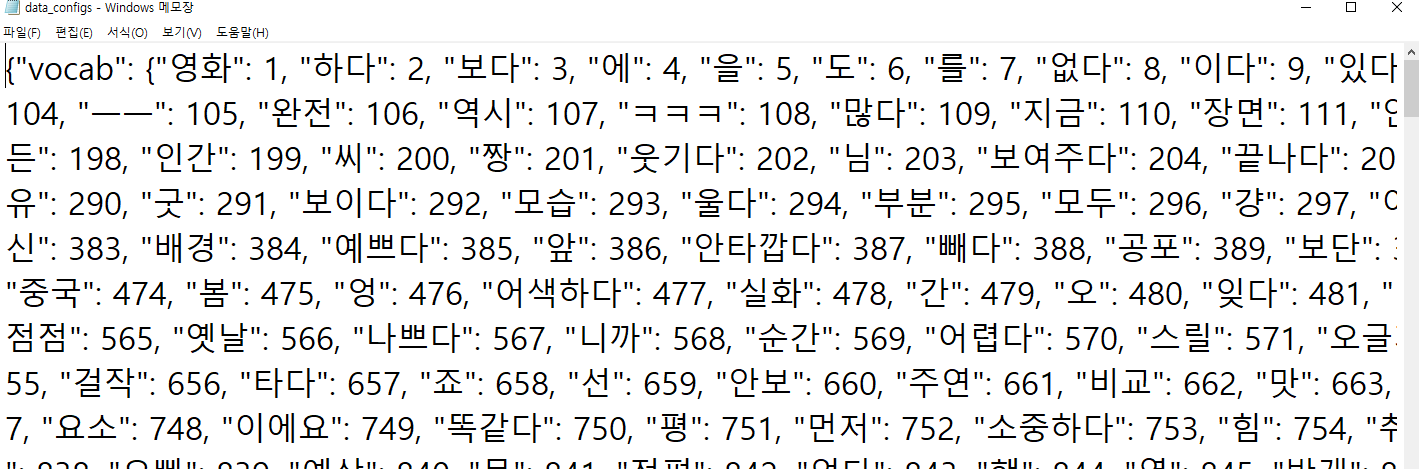

- 저장된 numpy로 변환된 학습/테스트 데이터 불러오기

In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
from tqdm import tqdm

#전처리 데이터 불러오기
DATA_PATH = 'cleandata/'
DATA_OUT = 'data_out/' # 없으면 생성
INPUT_TRAIN_DATA = 'nsmc_train_input.npy'
LABEL_TRAIN_DATA = 'nsmc_train_label.npy'
DATA_CONFIGS = 'data_configs.json'

In [16]:
train_input = np.load(open(DATA_PATH + INPUT_TRAIN_DATA,'rb'))
train_input[0]

array([463,  20, 265, 664,   0,   0,   0,   0], dtype=int32)

In [18]:
train_label = np.load(open(DATA_PATH + LABEL_TRAIN_DATA,'rb'))
prepro_configs = json.load(open(DATA_PATH+DATA_CONFIGS,'r', encoding="UTF8"))

In [19]:
# train_input ex 확인
# 전처리 후 남은 리뷰 단어가 >=8 인 리뷰
train_input[1]

array([ 604,    1,  219, 1459,   30,  969,  680,   24], dtype=int32)

In [24]:
# 이 리뷰는 문장값이 682,20,241,776인 리뷰임
# 이 수치에 대응하는 단어는 json파일로 저장했고 prepro_configs변수에 load 했음
train_input[0]

array([463,  20, 265, 664,   0,   0,   0,   0], dtype=int32)

In [25]:
# 숫자에 대응되는 단어 확인하기 위해 prepro_configs['vocab']의 key, value 뒤집기
tmp_dict = dict(map(reversed, prepro_configs["vocab"].items()))
tmp_dict

{1: '영화',
 2: '보다',
 3: '하다',
 4: '에',
 5: '을',
 6: '도',
 7: '를',
 8: '없다',
 9: '이다',
 10: '있다',
 11: '좋다',
 12: '너무',
 13: '다',
 14: '정말',
 15: '재밌다',
 16: '되다',
 17: '적',
 18: '만',
 19: '같다',
 20: '진짜',
 21: '으로',
 22: '로',
 23: '아니다',
 24: '않다',
 25: '점',
 26: '에서',
 27: '만들다',
 28: '과',
 29: '나오다',
 30: '연기',
 31: '평점',
 32: '최고',
 33: '내',
 34: '그',
 35: '나',
 36: '안',
 37: '인',
 38: '스토리',
 39: '생각',
 40: '못',
 41: '왜',
 42: '드라마',
 43: '게',
 44: '감동',
 45: '사람',
 46: '보고',
 47: '이렇다',
 48: '말',
 49: '아깝다',
 50: '고',
 51: '더',
 52: 'ㅋㅋ',
 53: '배우',
 54: '때',
 55: '와',
 56: '재미있다',
 57: '감독',
 58: '거',
 59: '그냥',
 60: '요',
 61: '재미',
 62: '시간',
 63: '내용',
 64: '뭐',
 65: '까지',
 66: '중',
 67: '주다',
 68: '재미없다',
 69: '자다',
 70: '좀',
 71: '쓰레기',
 72: '하고',
 73: '지루하다',
 74: '네',
 75: '모르다',
 76: '가다',
 77: '들다',
 78: '그렇다',
 79: '싶다',
 80: '지',
 81: '작품',
 82: '사랑',
 83: '알다',
 84: '하나',
 85: '다시',
 86: '볼',
 87: '마지막',
 88: '잘',
 89: '이건',
 90: '정도',
 91: '저',
 92: '완전',
 93: 'ㅋ',
 9

In [26]:
for vl in train_input[0][:4] :
    print(tmp_dict[vl])

더빙
진짜
짜증나다
목소리


In [27]:
for vl in train_input[1] :
    print(tmp_dict[vl])

초딩
영화
줄
오버
연기
조차
가볍다
않다


### 모델 구성

In [28]:
prepro_configs.keys()
# 'vocab' : 단어사전
# 'vocab_size' : 단어사전크기

dict_keys(['vocab', 'vocab_size'])

In [30]:
vocab_size = prepro_configs['vocab_size'] # 단어사전 크기
embbeding_size = 128, # 영화 단어가 1로 변환되었고, 1이라는 숫자가 128개의 실수벡터로 변환됨 
vocab_size

43757

## CNN으로 모델 생성
- Conv1D : 이미지등 2차원 데이터가 아닌 문장 같은 1차원의 sequential 데이터에 cnn 적용할 때 사용하는 함수


tf.keras.layers.Conv1D(
    filters,
    kernel_size,
    strides=1,
    padding='valid',
    data_format='channels_last',
    dilation_rate=1,
    groups=1,
    activation=None,
    use_bias=True,
    kernel_initializer='glorot_uniform',
    bias_initializer='zeros',
    kernel_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    bias_constraint=None,
    **kwargs
)

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Embedding, Conv1D, GlobalMaxPooling1D

In [32]:
model = Sequential()
# 128 크기의 벡터 생성
# 학습 진행하면서 embedding층의 밀집 벡터도 최적화 진행됨 >> 타겟값에 의해 가중치가 변환
model.add(Embedding(vocab_size, 128)) # 단어숫자를 밀집벡터(128개의 실수)로 변환시켜주는 모델 층 >> 모델에 주입되는 최종 input data
model.add(Conv1D(100, 5, activation="relu"))
model.add(GlobalMaxPooling1D())
model.add(Dense(250, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [33]:
# 학습데이터에서 비율만큼 분리해서 val_data로 사용
VALID_SPLIT = 0.1
BATCH_SIZE= 512
NUM_EPOCHS= 10
MAX_LEN = train_input.shape[1]
model_name="naver"

In [34]:
#검증 정확도를 통한 EarlyStopping 기능 및 모델 저장 방식 지정

checkpoint_path = DATA_OUT + model_name +'/naver.weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))



data_out/naver -- Folder create complete 



In [36]:
from tensorflow.keras.callbacks import ModelCheckpoint
earlystop_callback = EarlyStopping(monitor="val_accuracy", patience=2)
cp_callback = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True, save_weights_only=True)

In [35]:
# from tensorflow.keras.callbacks import ModelCheckpoint
# earlystop_callback = EarlyStopping(monitor="val_loss", patience=2)
# cp_callback = ModelCheckpoint(checkpoint_path, monitor="val_loss", save_best_only=True, save_weights_only=True)

In [37]:
# 검증데이터 직접 분할해놓고 사용할 수도 있고, fit() 파라미터 validation_split을 활용할수도 있음
history = model.fit(train_input,
                    train_label,
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS,
                    validation_split = VALID_SPLIT, # VALID_SPLIT의 값만큼 분리해서 검증데이터로 사용
                    callbacks=[earlystop_callback, cp_callback])

Epoch 1/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 24s 85ms/step - accuracy: 0.7323 - loss: 0.5144 - val_accuracy: 0.8223 - val_loss: 0.3912
Epoch 2/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 22s 82ms/step - accuracy: 0.8707 - loss: 0.3079 - val_accuracy: 0.8192 - val_loss: 0.4020
Epoch 3/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 20s 77ms/step - accuracy: 0.9270 - loss: 0.1928 - val_accuracy: 0.8141 - val_loss: 0.4565


In [38]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 8, 128)              │       5,600,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 4, 100)              │          64,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 100)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 250)                 │          25,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             251 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,071,493 (65.12 MB)

 Trainable params: 5,690,497 (21.71 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,380,996 (43.42 MB)

<hr/>

In [39]:
from tensorflow.keras.models import save_model

In [40]:
INPUT_TEST_DATA = 'nsmc_test_input.npy'
LABEL_TEST_DATA = 'nsmc_test_label.npy'
test_input = np.load(open(DATA_PATH+INPUT_TEST_DATA, 'rb'))
test_input = pad_sequences(test_input, maxlen=MAX_LEN, padding="post")

test_label = np.load(open(DATA_PATH+INPUT_TEST_DATA, 'rb'))

In [42]:
model.evaluate(test_input, test_label)

ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 8), output.shape=(None, 1)

In [ ]:
model.sava("model/reviews/keras")

In [ ]:
BATCH_SIZE = 512
NUM_EPOCHS = 10
VALID_SPLIT = 0.1
MAX_LEN = train_input.shape[1]
model_name = 'naver'

In [ ]:
# 모델 학습


Epoch 1/10
18/18 [==============================] - ETA: 0s - loss: 0.6896 - accuracy: 0.5408
Epoch 1: val_accuracy improved from -inf to 0.65500, saving model to data_out/naver\weights.h5
18/18 [==============================] - 8s 189ms/step - loss: 0.6896 - accuracy: 0.5408 - val_loss: 0.6786 - val_accuracy: 0.6550
Epoch 2/10
18/18 [==============================] - ETA: 0s - loss: 0.6136 - accuracy: 0.7464
Epoch 2: val_accuracy improved from 0.65500 to 0.73400, saving model to data_out/naver\weights.h5
18/18 [==============================] - 2s 145ms/step - loss: 0.6136 - accuracy: 0.7464 - val_loss: 0.5453 - val_accuracy: 0.7340
Epoch 3/10
18/18 [==============================] - ETA: 0s - loss: 0.3835 - accuracy: 0.8471
Epoch 3: val_accuracy improved from 0.73400 to 0.74400, saving model to data_out/naver\weights.h5
18/18 [==============================] - 3s 154ms/step - loss: 0.3835 - accuracy: 0.8471 - val_loss: 0.5419 - val_accuracy: 0.7440
Epoch 4/10
18/18 [================

## 평가하기

In [ ]:
##  전처리한 test data load


313/313 [==============================] - 3s 2ms/step - loss: 0.7764 - accuracy: 0.7530


[0.7764483690261841, 0.753000020980835]

In [ ]:
test_input[0]

array([1423,   87,    0,    0,    0,    0,    0,    0], dtype=int32)

## 예측하기

In [ ]:
# 1. 모델 불러오기 
preModel = tf.keras.models.load_model("./model/review.keras")

In [ ]:
# 새로 입력될 리뷰 텍스트에 대한 전처리에는
# 학습에 사용된 텍스트 전처리 모듈을 그대로 적용해줘야 함
# 특히 토큰은 학습에서 사용된 단어 index를 그대로 사욯해야 함

In [45]:
import numpy as np
import pandas as pd
import re
import json
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [46]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
from tqdm import tqdm

In [48]:
# 새로 입력되는 리뷰 텍스트 형태소 분석 진행하고
# 불용어 제거하고
# 저장해놓은 vocab 이용해서 token화 진행
okt = Okt()
tokenizer = Tokenizer()


AttributeError: Java package 'kr.lucypark.okt' is not valid

In [49]:
# 학습에서 사용한 단어 인덱스를 불러오기
DATA_CONFIGS = "cleandata/data_configs.json"
prepro_configs = json.load(open(DATA_CONFIGS, 'r'))

word_vocab = prepro_configs["vocab"]
word_vocab

UnicodeDecodeError: 'cp949' codec can't decode byte 0xec in position 12: illegal multibyte sequence

In [143]:
# 새로 토큰 객체 구성하고, 
# 새로운 토큰화작업을 진행하는게 아닌
# 기존에 토큰화된 사전(단어 인덱스)에 새로운 문장에 주입해서 사용하는것

tokenizer.fit_on_texts(word_vocab)

In [144]:
tokenizer.word_index

{'영화': 1,
 '하다': 2,
 '보다': 3,
 '에': 4,
 '을': 5,
 '도': 6,
 '를': 7,
 '없다': 8,
 '이다': 9,
 '있다': 10,
 '좋다': 11,
 '다': 12,
 '정말': 13,
 '너무': 14,
 '재밌다': 15,
 '만': 16,
 '적': 17,
 '같다': 18,
 '되다': 19,
 '진짜': 20,
 '점': 21,
 '아니다': 22,
 '으로': 23,
 '로': 24,
 '않다': 25,
 '에서': 26,
 '나오다': 27,
 '연기': 28,
 '과': 29,
 '평점': 30,
 '만들다': 31,
 '최고': 32,
 '나': 33,
 '안': 34,
 '인': 35,
 '내': 36,
 '그': 37,
 '못': 38,
 '스토리': 39,
 '사람': 40,
 '드라마': 41,
 '왜': 42,
 '게': 43,
 '보고': 44,
 '고': 45,
 '감동': 46,
 '생각': 47,
 '이렇다': 48,
 '아깝다': 49,
 '때': 50,
 '감독': 51,
 'ㅋㅋ': 52,
 '말': 53,
 '그냥': 54,
 '시간': 55,
 '배우': 56,
 '더': 57,
 '재미없다': 58,
 '거': 59,
 '내용': 60,
 '요': 61,
 '재미': 62,
 '지루하다': 63,
 '재미있다': 64,
 '와': 65,
 '하고': 66,
 '중': 67,
 '가다': 68,
 '자다': 69,
 '주다': 70,
 '뭐': 71,
 '까지': 72,
 '모르다': 73,
 '좀': 74,
 '쓰레기': 75,
 '작품': 76,
 '들다': 77,
 '네': 78,
 '알다': 79,
 '하나': 80,
 '지': 81,
 '싶다': 82,
 '사랑': 83,
 '이건': 84,
 '그렇다': 85,
 '볼': 86,
 'ㅋ': 87,
 '정도': 88,
 '다시': 89,
 '잘': 90,
 '액션': 91,
 '이렇게': 92,
 '개': 93,
 '

#### 새로운 리뷰 입력 받아서 전처리 진행 후 예측 코드

In [44]:
import itertools
import tensorflow as tf

In [47]:
MAX_LENGTH = 8

sentence = input("긍부정 분류할 리뷰 문장 입력 : ")

# 새로 입력된 문장 전처리
sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣\\s ]','', sentence)
stopwords = ['은','는','이','가','하','아','것','들','의','있','되','수','보','주','등','한']
sentence = okt.morphs(sentence, stem=True)
sentence = [word for word in sentence if not word in stopwords]
# print(sentence)

vector = tokenizer.texts_to_sequences(sentence)
pad_new = pad_sequences([vector], maxlen = MAX_LENGTH, padding="post")

preModel = tf.keras.models.load_model("./model/review.keras")

# 예측
predictions = preModel.predict(pad_new)
predictions = float(predictions)
# print(predictions)

if (predictions > 0.5) :
    print("{:.2f} 확률로 긍정 리뷰 입니다.\n".format(predictions*100))
else :
    print("{:.2f} 확률로 부정 리뷰 입니다.\n".format(1-predictions*100))

긍부정 분류할 리뷰 문장 입력 :  영화가 재미 없어요


NameError: name 'okt' is not defined

In [ ]:
# 모델 불러오기


### 학습 후 완성된 모델을 저장했다고 가정하면
- 새로 입력될 텍스트의 전처리에는
    - 학습에 사용된 텍스트 전처리 모듈을 그대로 적용해 줘야 함
    - **특히 토크나이저는 학습에서 사용된 단어 index를 그대로 사용해야 함**

In [ ]:
import numpy as np
import pandas as pd
import re
import json
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
okt = Okt()
tokenizer  = Tokenizer()

# 학습에서 사용한 단어 인덱스 불러오기


12352

In [ ]:

# print(word_vocab)
# 새로 tokenizer를 진행하는 것이 아닌 기존에 만든 tokenizer의 형태를 그대로
# 사용해야 하므로 위에서 만들어 저장 해 놓은 word index를 가져와서
# tokenizer를 구성
# fit_on_texts()


In [ ]:
import itertools
import tensorflow as tf

In [ ]:
MAX_LENGTH = 8 #문장최대길이

sentence = input('감성분석할 문장을 입력해 주세요.: ')

# 새로 입력된 문장을 전처리
sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣\\s ]','', sentence)
stopwords = ['은','는','이','가','하','아','것','들','의','있','되','수','보','주','등','한'] # 불용어 추가할 것이 있으면 이곳에 추가
sentence = okt.morphs(sentence, stem=True) # 토큰화
sentence = [word for word in sentence if not word in stopwords] # 불용어 제거
print(sentence)

vector  = tokenizer.texts_to_sequences(sentence)
pad_new = pad_sequences([vector], maxlen = MAX_LENGTH,padding='post') # 패딩
model = tf.keras.models.load_model('./model/review.keras')
predictions = model.predict(pad_new)
print(predictions)
predictions = float(predictions)

if(predictions > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(predictions * 100))
else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - predictions) * 100))

감성분석할 문장을 입력해 주세요.: 짱 재밌어요
['짱', '재밌다']
1/1 [==============================] - 0s 98ms/step
[[0.99723214]]
99.72% 확률로 긍정 리뷰입니다.

